In [1]:
!nvidia-smi

Mon Jan 19 15:07:13 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


# Задача 1

In [19]:
%%writefile task_1_array_addition.cu

#include <iostream>       // Стандартный ввод-вывод
#include <vector>         // Контейнер для хранения данных на CPU
#include <chrono>         // Библиотека для высокоточного измерения времени на CPU
#include <random>         // Генератор случайных чисел
#include <cuda_runtime.h> // Основные функции CUDA API
#include <cmath>          // Математические функции (для fabs)

// Размер блока потоков (количество потоков в одной группе на GPU)
#define BLOCK_SIZE 256
// Границы для генерации случайных чисел
#define RAND_MIN_VAL -100000
#define RAND_MAX_VAL  100000

// ================= CUDA KERNEL (Ядро) =================
// __global__ указывает, что функция вызывается с CPU, а исполняется на GPU
__global__ void vector_add_gpu(const float* A, const float* B, float* C, int n) {
    // Вычисление уникального индекса элемента для каждого потока
    // blockIdx.x - номер блока, blockDim.x - количество потоков в блоке, threadIdx.x - номер потока внутри блока
    int id = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверка, чтобы индекс не вышел за пределы массива (если N не кратно BLOCK_SIZE)
    if (id < n) {
        C[id] = A[id] + B[id]; // Само сложение
    }
}

// ================= CPU VERSION =================
// Обычная последовательная реализация сложения векторов на центральном процессоре
void vector_add_cpu(const float* A, const float* B, float* C, int n) {
    for (int i = 0; i < n; ++i) {
        C[i] = A[i] + B[i];
    }
}

// ================= PRINT FUNCTION =================
// Функция для вывода первых и последних элементов массива для визуальной проверки
void print_edges(const std::vector<float>& A,
                 const std::vector<float>& B,
                 const std::vector<float>& C,
                 int N) {
    int count = std::min(10, N); // Выводим максимум 10 элементов

    std::cout << "First " << count << " elements:\n";
    for (int i = 0; i < count; ++i) {
        std::cout << "A[" << i << "]=" << A[i]
                  << "  B[" << i << "]=" << B[i]
                  << "  C[" << i << "]=" << C[i] << "\n";
    }

    if (N > 10) {
        std::cout << "Last " << count << " elements:\n";
        for (int i = N - count; i < N; ++i) {
            std::cout << "A[" << i << "]=" << A[i]
                      << "  B[" << i << "]=" << B[i]
                      << "  C[" << i << "]=" << C[i] << "\n";
        }
    }
}

// ================= MAIN =================
int main() {
    // Набор размеров векторов для тестирования (от 10 до 10 миллионов элементов)
    std::vector<int> sizes = {
        10, 100, 1000, 10000, 100000, 1000000, 10000000
    };

    // Настройка генератора случайных чисел
    std::random_device rd;  // Инициализатор
    std::mt19937 gen(rd()); // Генератор (Вихрь Мерсенна)
    std::uniform_int_distribution<> dist(RAND_MIN_VAL, RAND_MAX_VAL); // Равномерное распределение

    std::cout << "Size\tCPU(ms)\tGPU(ms)\tSpeedup\n";

    // Цикл по всем тестовым размерам векторов
    for (int N : sizes) {
        size_t bytes = N * sizeof(float); // Объем памяти в байтах

        // Создание векторов в оперативной памяти (Host)
        std::vector<float> A(N), B(N), C_cpu(N), C_gpu(N);

        // Заполнение исходных данных случайными числами
        for (int i = 0; i < N; ++i) {
            A[i] = static_cast<float>(dist(gen));
            B[i] = static_cast<float>(dist(gen));
        }

        // ================= CPU TIMING =================
        auto cpu_start = std::chrono::high_resolution_clock::now(); // Засекаем время старта на CPU
        vector_add_cpu(A.data(), B.data(), C_cpu.data(), N);        // Вычисление на CPU
        auto cpu_end = std::chrono::high_resolution_clock::now();   // Засекаем время конца на CPU
        double cpu_time =
            std::chrono::duration<double, std::milli>(cpu_end - cpu_start).count(); // Разница в миллисекундах

        // ================= GPU MEMORY ALLOCATION =================
        float *d_A, *d_B, *d_C; // Указатели для памяти на видеокарте (Device)
        cudaMalloc(&d_A, bytes); // Выделение памяти на GPU для вектора A
        cudaMalloc(&d_B, bytes); // Выделение памяти на GPU для вектора B
        cudaMalloc(&d_C, bytes); // Выделение памяти на GPU для вектора результата C

        // Копирование данных из ОЗУ в видеопамять
        cudaMemcpy(d_A, A.data(), bytes, cudaMemcpyHostToDevice);
        cudaMemcpy(d_B, B.data(), bytes, cudaMemcpyHostToDevice);

        // Расчет количества блоков: (N / размер блока) с округлением вверх
        int gridSize = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;

        // ================= GPU TIMING =================
        cudaEvent_t start, stop; // Создание специальных событий CUDA для замера времени
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start); // Фиксация события старта
        // Запуск ядра: <<<количество_блоков, количество_потоков_в_блоке>>>
        vector_add_gpu<<<gridSize, BLOCK_SIZE>>>(d_A, d_B, d_C, N);

        // Проверка на наличие ошибок при запуске ядра
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            std::cerr << "CUDA kernel error: "
                      << cudaGetErrorString(err) << std::endl;
        }

        // Ожидание завершения всех операций на GPU перед замером времени
        cudaDeviceSynchronize();

        cudaEventRecord(stop);        // Фиксация события завершения
        cudaEventSynchronize(stop);   // Ожидание фактической записи события stop

        float gpu_time = 0.0f;
        cudaEventElapsedTime(&gpu_time, start, stop); // Расчет времени между событиями (в мс)

        // Копирование результата вычислений обратно с GPU на CPU
        cudaMemcpy(C_gpu.data(), d_C, bytes, cudaMemcpyDeviceToHost);

        // ================= VALIDATION =================
        // Проверка, совпадают ли результаты CPU и GPU с небольшой погрешностью
        bool correct = true;
        for (int i = 0; i < N; ++i) {
            if (fabs(C_cpu[i] - C_gpu[i]) > 1e-5) {
                correct = false;
                break;
            }
        }

        // Вывод итоговой таблицы: размер, время CPU, время GPU и ускорение
        std::cout << N << "\t"
                  << cpu_time << "\t"
                  << gpu_time << "\t"
                  << (cpu_time / gpu_time)
                  << (correct ? "" : " (ERROR)") << "\n";

        // Предпросмотр данных для текущего размера N
        std::cout << "=== Array preview for N = " << N << " ===\n";
        print_edges(A, B, C_gpu, N);
        std::cout << "========================================\n\n";

        // ================= CLEANUP =================
        cudaFree(d_A);           // Освобождение видеопамяти
        cudaFree(d_B);
        cudaFree(d_C);
        cudaEventDestroy(start); // Удаление событий замера времени
        cudaEventDestroy(stop);
    }

    return 0; // Завершение программы
}

Writing task_1_array_addition.cu


In [20]:
!nvcc task_1_array_addition.cu -o task_1_array_addition -arch=sm_75
!./task_1_array_addition

Size	CPU(ms)	GPU(ms)	Speedup
10	0.000306	0.104704	0.00292252
=== Array preview for N = 10 ===
First 10 elements:
A[0]=50092  B[0]=-18141  C[0]=31951
A[1]=-2501  B[1]=17591  C[1]=15090
A[2]=92663  B[2]=-6639  C[2]=86024
A[3]=-9366  B[3]=93855  C[3]=84489
A[4]=-75948  B[4]=8728  C[4]=-67220
A[5]=69988  B[5]=46453  C[5]=116441
A[6]=-48516  B[6]=65302  C[6]=16786
A[7]=44962  B[7]=27355  C[7]=72317
A[8]=84012  B[8]=48449  C[8]=132461
A[9]=79334  B[9]=-62293  C[9]=17041

100	0.000486	0.016224	0.0299556
=== Array preview for N = 100 ===
First 10 elements:
A[0]=-62535  B[0]=72279  C[0]=9744
A[1]=44123  B[1]=-93470  C[1]=-49347
A[2]=-61278  B[2]=-37556  C[2]=-98834
A[3]=-24288  B[3]=18997  C[3]=-5291
A[4]=41570  B[4]=-24389  C[4]=17181
A[5]=9085  B[5]=96654  C[5]=105739
A[6]=25472  B[6]=52926  C[6]=78398
A[7]=-87555  B[7]=97528  C[7]=9973
A[8]=-70508  B[8]=31044  C[8]=-39464
A[9]=-66881  B[9]=-72712  C[9]=-139593
Last 10 elements:
A[90]=26002  B[90]=-66843  C[90]=-40841
A[91]=-77719  B[91]=7500

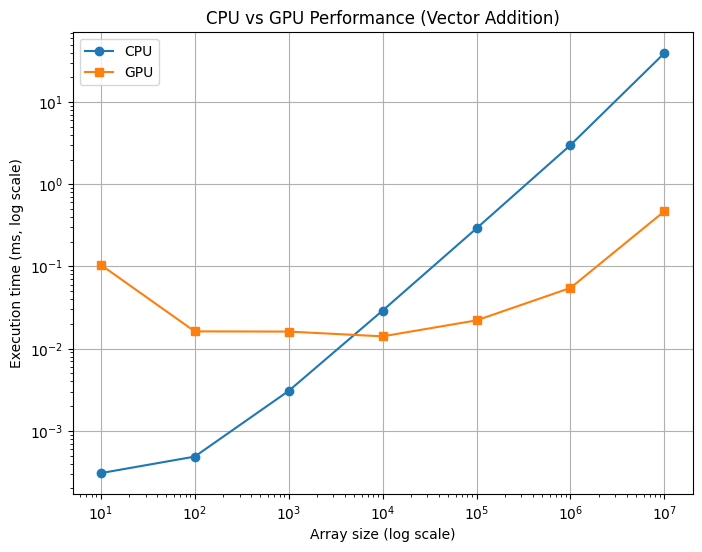

In [21]:
import matplotlib.pyplot as plt

# Данные из эксперимента
sizes = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
cpu_time = [0.000306, 0.000486, 0.003059, 0.029029, 0.290714, 2.9968, 39.3724]
gpu_time = [0.104704, 0.016224, 0.016128, 0.014112, 0.02208, 0.054784, 0.469408]

plt.figure(figsize=(8, 6))

plt.plot(sizes, cpu_time, marker='o', label='CPU')
plt.plot(sizes, gpu_time, marker='s', label='GPU')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Array size (log scale)')
plt.ylabel('Execution time (ms, log scale)')
plt.title('CPU vs GPU Performance (Vector Addition)')

plt.legend()
plt.grid(True)

plt.show()

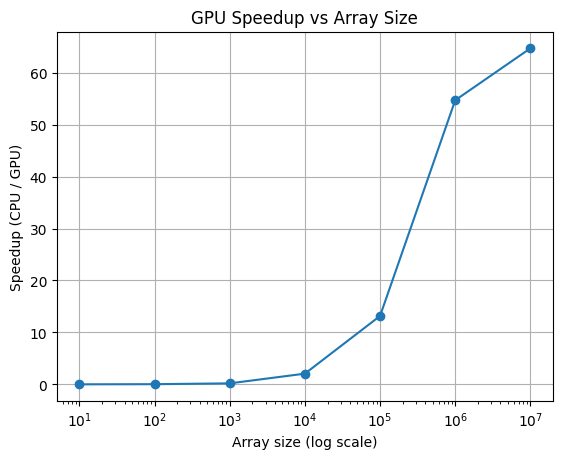

In [22]:
import matplotlib.pyplot as plt

sizes = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
speedup = [0.00292252, 0.0299556, 0.18967, 2.05704, 13.1664, 54.7021, 64.7035]

plt.figure()
plt.plot(sizes, speedup, marker='o')
plt.xscale('log')
plt.xlabel('Array size (log scale)')
plt.ylabel('Speedup (CPU / GPU)')
plt.title('GPU Speedup vs Array Size')
plt.grid(True)

plt.show()

# Задача 2

In [23]:
%%writefile task_2_matrix_multiplication.cu

#include <iostream>    // Стандартный поток ввода-вывода
#include <vector>      // Контейнер векторов C++
#include <random>      // Библиотека для генерации случайных чисел
#include <cuda_runtime.h> // Основной заголовочный файл CUDA

// Размер квадратного блока потоков (16x16 = 256 потоков в блоке)
#define BLOCK_SIZE 16
// Диапазон случайных чисел для заполнения матриц
#define RAND_MIN_VAL -100
#define RAND_MAX_VAL  100

// ================= CUDA KERNEL (Ядро) =================
// Функция, выполняемая на GPU. Каждый поток вычисляет один элемент результирующей матрицы C.
__global__ void matrix_mul_gpu(
    const int* A, // Указатель на матрицу A в видеопамяти
    const int* B, // Указатель на матрицу B в видеопамяти
    int* C,       // Указатель на матрицу результата C в видеопамяти
    int N         // Размер стороны матрицы (NxN)
) {
    // Вычисляем индекс строки и столбца для текущего потока в двумерной сетке
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверка на выход за границы матрицы (важно, если N не кратно BLOCK_SIZE)
    if (row < N && col < N) {
        int sum = 0; // Временная переменная для накопления суммы (скалярное произведение)
        // Цикл по строке A и столбцу B
        for (int k = 0; k < N; ++k) {
            // Формула индексации в одномерном массиве для 2D данных: [строка * ширина + столбец]
            sum += A[row * N + k] * B[k * N + col];
        }
        // Запись итогового значения в ячейку матрицы C
        C[row * N + col] = sum;
    }
}

// ================= CPU VERSION =================
// Классическое умножение матриц с тремя вложенными циклами (O(N^3))
void matrix_mul_cpu(
    const int* A,
    const int* B,
    int* C,
    int N
) {
    for (int i = 0; i < N; ++i) // Проход по строкам
        for (int j = 0; j < N; ++j) { // Проход по столбцам
            int sum = 0;
            for (int k = 0; k < N; ++k) // Скалярное произведение строки на столбец
                sum += A[i * N + k] * B[k * N + j];
            C[i * N + j] = sum; // Сохранение результата
        }
}

// ================= PRINT MATRIX =================
// Вспомогательная функция для вывода матрицы в консоль в удобном виде
void print_matrix(const std::vector<int>& M, int N, const std::string& name) {
    std::cout << name << ":\n";
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j)
            std::cout << M[i * N + j] << "\t"; // Табуляция для выравнивания колонок
        std::cout << "\n";
    }
    std::cout << "\n";
}

// ================= MAIN =================
int main() {
    // Тестовые размеры маленьких матриц для отладки и проверки корректности
    std::vector<int> sizes = {2, 3, 4, 5, 10};

    // Инициализация генератора случайных чисел (фикс. зерно 42 для повторяемости)
    std::mt19937 gen(42);
    std::uniform_int_distribution<> dist(RAND_MIN_VAL, RAND_MAX_VAL);

    for (int N : sizes) {
        std::cout << "==============================\n";
        std::cout << "Matrix size: " << N << "x" << N << "\n";

        // Расчет объема памяти для матрицы NxN
        size_t bytes = N * N * sizeof(int);

        // Хост-векторы (память на CPU)
        std::vector<int> A(N * N), B(N * N), C_cpu(N * N), C_gpu(N * N);

        // Заполнение матриц A и B случайными числами
        for (auto& x : A) x = dist(gen);
        for (auto& x : B) x = dist(gen);

        // Вычисление на CPU для эталона
        matrix_mul_cpu(A.data(), B.data(), C_cpu.data(), N);

        // Подготовка памяти на GPU (Device)
        int *d_A, *d_B, *d_C;
        cudaMalloc(&d_A, bytes); // Выделение памяти под A
        cudaMalloc(&d_B, bytes); // Выделение памяти под B
        cudaMalloc(&d_C, bytes); // Выделение памяти под результат C

        // Копирование входных данных с Host на Device
        cudaMemcpy(d_A, A.data(), bytes, cudaMemcpyHostToDevice);
        cudaMemcpy(d_B, B.data(), bytes, cudaMemcpyHostToDevice);

        // Определение конфигурации запуска ядра
        // dim3 - специальный тип CUDA для задания 2D/3D размеров
        dim3 block(BLOCK_SIZE, BLOCK_SIZE); // Блок 16x16 потоков
        dim3 grid(
            (N + BLOCK_SIZE - 1) / BLOCK_SIZE, // Количество блоков по горизонтали
            (N + BLOCK_SIZE - 1) / BLOCK_SIZE  // Количество блоков по вертикали
        );

        // Запуск ядра на исполнение
        matrix_mul_gpu<<<grid, block>>>(d_A, d_B, d_C, N);

        // Ожидание завершения работы GPU (синхронизация)
        cudaDeviceSynchronize();

        // Копирование результата обратно в память CPU
        cudaMemcpy(C_gpu.data(), d_C, bytes, cudaMemcpyDeviceToHost);

        // Вывод всех матриц для визуальной проверки
        print_matrix(A, N, "Matrix A");
        print_matrix(B, N, "Matrix B");
        print_matrix(C_cpu, N, "Matrix C (CPU)");
        print_matrix(C_gpu, N, "Matrix C (GPU)");

        // Валидация: сравнение каждого элемента CPU и GPU версий
        bool correct = true;
        for (int i = 0; i < N * N; ++i)
            if (C_cpu[i] != C_gpu[i]) {
                correct = false;
                break;
            }

        std::cout << "Correctness: "
                  << (correct ? "OK" : "ERROR") << "\n";

        // Освобождение выделенной видеопамяти
        cudaFree(d_A);
        cudaFree(d_B);
        cudaFree(d_C);
    }

    return 0;
}

Writing task_2_matrix_multiplication.cu


In [24]:
!nvcc task_2_matrix_multiplication.cu -o task_2_matrix_multiplication -arch=sm_75
!./task_2_matrix_multiplication

Matrix size: 2x2
Matrix A:
-25	60	
91	-64	

Matrix B:
47	56	
20	19	

Matrix C (CPU):
25	-260	
2997	3880	

Matrix C (GPU):
25	-260	
2997	3880	

Correctness: OK
Matrix size: 3x3
Matrix A:
-69	-11	-69	
-80	-89	-8	
74	-33	20	

Matrix B:
-72	42	30	
-96	-89	94	
45	67	88	

Matrix C (CPU):
2919	-6542	-9176	
13944	4025	-11470	
-1260	7385	878	

Matrix C (GPU):
2919	-6542	-9176	
13944	4025	-11470	
-1260	7385	878	

Correctness: OK
Matrix size: 4x4
Matrix A:
-58	-100	-64	99	
-64	24	-39	22	
5	-99	-14	-96	
-42	5	22	-20	

Matrix B:
-72	-91	-42	95	
-27	-54	-9	-82	
57	24	-60	-24	
3	97	19	-7	

Matrix C (CPU):
3525	18745	9057	3533	
1803	5726	5230	-7266	
1227	-4757	-303	9601	
4083	2140	19	-4788	

Matrix C (GPU):
3525	18745	9057	3533	
1803	5726	5230	-7266	
1227	-4757	-303	9601	
4083	2140	19	-4788	

Correctness: OK
Matrix size: 5x5
Matrix A:
-91	72	22	36	-66	
-10	-87	-98	90	89	
94	13	62	-23	-39	
-97	-81	-54	37	-52	
-12	37	-76	22	-1	

Matrix B:
67	-94	-66	82	-22	
-48	-64	33	51	-38	
-15	4	-59	9	14	
-63	-94	94	